# Big Data Coursework - Questions

## Data Processing and Machine Learning in the Cloud

This is the **INM432 Big Data coursework 2025**.
This coursework contains extended elements of **theory** and **practice**, mainly around parallelisation of tasks withSpark and a bit about parallel training using TensorFlow.   

## Code and Report

Your tasks parallelization of tasks in PySpark, extension, evaluation, and theoretical reflection.
Please complete and submit the **coding tasks** in a copy of **this notebook**.
Write your code in the **indicated cells** and **include** the **output** in the submitted notebook.  
Make sure that **your code contains comments** on its **stucture** and explanations of its **purpose**.

Provide also a **report** with the **textual answers in a separate document**.  
Include **screenshots** from the Google Cloud web interface (don't use the SCREENSHOT function that Google provides, but take a picture of the graphs you see for the VMs) and result tables, as well as written text about the analysis.



## Submission

Download and submit **your version of this notebook** as an **.ipynb** file and also submit a **shareable link** to your notebook on Colab in your report (created with the Colab 'Share' function) (**and don’t change the online version after submission**).

Further, provide your **report as a PDF document**. **State the number of words** in the document at the end. The report should **not have more than 2000 words**.  


Please also submit **a PDF of your Jupyter notebook**.

## Introduction and Description

This coursework focuses on parallelisation and scalability in the cloud with Spark and TesorFlow/Keras.
We start with code based on **lessons 3 and 4** of the [*Fast and Lean Data Science*](https://github.com/GoogleCloudPlatform/training-data-analyst/tree/master/courses/fast-and-lean-data-science) course by Martin Gorner.
The course is based on Tensorflow for data processing and MachineLearning.
Tensorflow's data processing approach is somewhat similar to that of Spark, but you don't need to study Tensorflow, just make sure you understand the high-level structure.  
What we will do here is **parallelising** **pre-processing**, and **measuring** performance, and we will perform **evaluation** and **analysis** on the cloud performance, as well as **theoretical discussion**.

This coursework contains **3 sections**.

### Section 0

This section just contains some necessary code for setting up the environment. It has no tasks for you (but do read the code and comments).

### Section 1
Section 1 is about preprocessing a set of image files.
We will work with a public dataset “Flowers” (3600 images, 5 classes).
This is not a vast dataset, but it keeps the tasks more manageable for development and you can scale up later, if you like.

In **'Getting Started'** we will work through the data preprocessing code from *Fast and Lean Data Science* which uses TensorFlow's `tf.data` package.
There is no task for you here, but you will need to re-use some of this code later.

In **Task 1** you will **parallelise the data preprocessing in Spark**, using Google Cloud (GC) Dataproc.
This involves adapting the code from 'Getting Started' to use Spark and running it in the cloud.

### Section 2
In **Section 2** we are going to **measure the speed of reading data** in the cloud. In **Task  2** we will **paralellize the measuring** of different configurations **using Spark**.

### Section 3

This section is about the theoretical discussion, based on one paper, in **Task 3**. The answers should be given in the PDF report.

### General points

For **all coding tasks**, take the **time of the operations** and for the cloud operations, get performance **information from the web interfaces** for your reporting and analysis.

The **tasks** are **mostly independent** of each other. The later tasks can mostly be addressed without needing the solution to the earlier ones.  

# Section 0: Set-up

As usual, you need to run the **imports and authentication every time you work with this notebook**. Use the **local Spark** installation for development before you send jobs to the cloud.

Read through this section once and **fill in the project ID the first time**, then you can just step straight throught this at the beginning of each session - except for the two authentication cells.

### Imports

We import some **packages that will be needed throughout**.
For the **code that runs in the cloud**, we will need **separate import sections** that will need to be partly different from the one below.


In [1]:
import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle

Tensorflow version 2.18.0


### Cloud and Drive authentication

This is for **authenticating with with GCS Google Drive**, so that we can create and use our own buckets and access Dataproc and AI-Platform.

This section **starts with the two interactive authentications**.

First, we mount Google Drive for persistent local storage and create a directory `DB-CW` thay you can use for this work.
Then we'll set up the cloud environment, including a storage bucket.

In [2]:
print('Mounting google drive...')
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive"
!mkdir BD-CW
%cd "/content/drive/MyDrive/BD-CW"

Mounting google drive...
Mounted at /content/drive
/content/drive/MyDrive
mkdir: cannot create directory ‘BD-CW’: File exists
/content/drive/MyDrive/BD-CW


Next, we authenticate with the GCS to enable access to Dataproc and AI-Platform.

In [3]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

It is useful to **create a new Google Cloud project** for this coursework. You can do this on the [GC Console page](https://console.cloud.google.com) by clicking on the entry at the top, right of the *Google Cloud Platform* and choosing *New Project*. **Copy** the **generated project ID** to the next cell. Also **enable billing** and the **Compute, Storage and Dataproc** APIs like we did during the labs.

We also specify the **default project and region**. The REGION should be `europe-west2` as it is closest to us geographically.
This way we don't have to specify this information every time we access the cloud.  

In [4]:
PROJECT = 'bd-coursework-zeynepdagci'  ### USE YOUR GOOGLE CLOUD PROJECT ID HERE. ###
!gcloud config set project $PROJECT
REGION = 'europe-west2'
CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud config set compute/region $REGION
!gcloud config set dataproc/region $REGION

!gcloud config list # show some information

Updated property [core/project].
Updated property [compute/region].
Updated property [dataproc/region].
[component_manager]
disable_update_check = True
[compute]
region = europe-west2
[core]
account = zeynepdagci09@gmail.com
project = bd-coursework-zeynepdagci
[dataproc]
region = europe-west2

Your active configuration is: [default]


With the cell below, we **create a storage bucket** that we will use later for **global storage**.
If the bucket exists you will see a "ServiceException: 409 ...", which does not cause any problems.
**You must create your own bucket to have write access.**

In [5]:
BUCKET = 'gs://{}-storage'.format(PROJECT)
!gsutil mb $BUCKET

Creating gs://bd-coursework-zeynepdagci-storage/...
ServiceException: 409 A Cloud Storage bucket named 'bd-coursework-zeynepdagci-storage' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


The cell below just **defines some routines for displaying images** that will be **used later**. You can see the code by double-clicking, but you don't need to study this.

In [7]:
#@title Utility functions for image display **[RUN THIS TO ACTIVATE]** { display-mode: "form" }
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(str(label.numpy()), fontsize=16)
    # plt.title(label.numpy().decode(), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

def dataset_to_numpy_util(dataset, N):
    dataset = dataset.batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;

  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()


### Install Spark locally for quick testing

You can use the cell below to **install Spark locally on this Colab VM** (like in the labs), to do quicker small-scale interactive testing. Using Spark in the cloud with **Dataproc is still required for the final version**.


In [6]:
%cd
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq >> /dev/null # send any output to null device
!tar -xzf "/content/drive/My Drive/Big_Data/data/spark/spark-3.5.0-bin-hadoop3.tgz" # unpack

!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/root/spark-3.5.0-bin-hadoop3"
import findspark
findspark.init()
import pyspark
print(pyspark.__version__)
sc = pyspark.SparkContext.getOrCreate()
print(sc)

/root
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
3.5.0
<SparkContext master=local[*] appName=pyspark-shell>


# Section 1: Data pre-processing

This section is about the **pre-processing of a dataset** for deep learning.
We first look at a ready-made solution using Tensorflow and then we build a implement the same process with Spark.
The tasks are about **parallelisation** and **analysis** the performance of the cloud implementations.

## 1.1 Getting started

In this section, we get started with the data pre-processing. The code is based on lecture 3 of the 'Fast and Lean Data Science' course.

**This code is using the TensorFlow** `tf.data` package, which supports map functions, similar to Spark. Your **task** will be to **re-implement the same approach in Spark**.  


We start by **setting some variables for the *Flowers* dataset**.

In [7]:
GCS_PATTERN = 'gs://cloud-samples-data/ai-platform/flowers_tfrec/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
    # labels for the data

We **read the image files** from the public GCS bucket that contains the *Flowers* dataset.
**TensorFlow** has **functions** to execute glob patterns that we use to calculate the the number of images in total and per partition (rounded up as we cannont deal with parts of images).

In [8]:
nb_images = len(tf.io.gfile.glob(GCS_PATTERN)) # number of images
partition_size = math.ceil(1.0 * nb_images / PARTITIONS) # images per partition (float)
print("GCS_PATTERN matches {} images, to be divided into {} partitions with up to {} images each.".format(nb_images, PARTITIONS, partition_size))


GCS_PATTERN matches 3670 images, to be divided into 16 partitions with up to 230 images each.


### Map functions

In order to read use the images for learning, they need to be **preprocessed** (decoded, resized, cropped, and potentially recompressed).
Below are **map functions** for these steps.
You **don't need to study** the **internals of these functions** in detail.

In [40]:
def decode_jpeg_and_label(filepath):
    # extracts the image data and creates a class label, based on the filepath
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(image, label):
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image
    # so that it fills the TARGET_SIZE entirely with no black bars
    # and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_image(image, label):
    # this reduces the amount of data, but takes some time
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label

With `tf.data`, we can apply decoding and resizing as map functions.

In [41]:
dsetFiles = tf.data.Dataset.list_files(GCS_PATTERN) # This also shuffles the images
dsetDecoded = dsetFiles.map(decode_jpeg_and_label)
dsetResized = dsetDecoded.map(resize_and_crop_image)

We can also look at some images using the image display function defined above (the one with the hidden code).

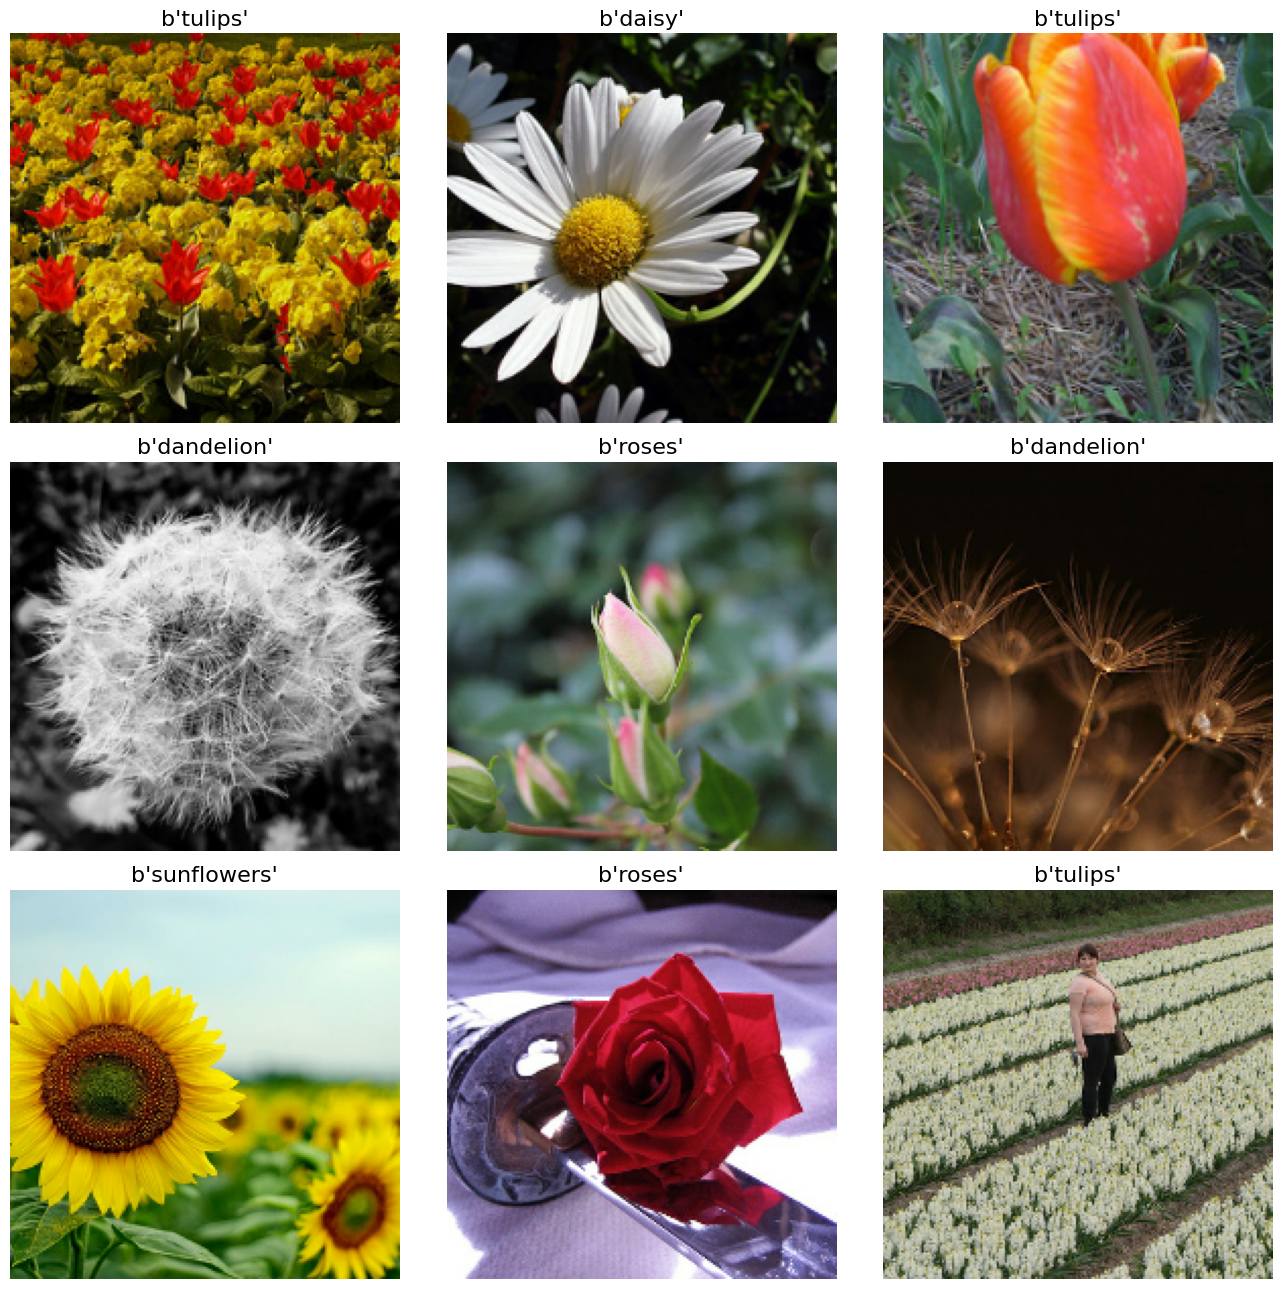

In [42]:
display_9_images_from_dataset(dsetResized)

Now, let's test continuous reading from the dataset. We can see that reading the first 100 files already takes some time.

In [43]:
sample_set = dsetResized.batch(10).take(10) # take 10 batches of 10 images for testing
for image, label in sample_set:
    print("Image batch shape {}, {})".format(image.numpy().shape,
        [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (10, 192, 192, 3), ['tulips', 'tulips', 'daisy', 'daisy', 'daisy', 'roses', 'daisy', 'dandelion', 'daisy', 'sunflowers'])
Image batch shape (10, 192, 192, 3), ['roses', 'sunflowers', 'dandelion', 'dandelion', 'dandelion', 'sunflowers', 'roses', 'sunflowers', 'sunflowers', 'roses'])
Image batch shape (10, 192, 192, 3), ['daisy', 'sunflowers', 'sunflowers', 'tulips', 'roses', 'dandelion', 'sunflowers', 'tulips', 'daisy', 'dandelion'])
Image batch shape (10, 192, 192, 3), ['tulips', 'sunflowers', 'sunflowers', 'dandelion', 'tulips', 'dandelion', 'sunflowers', 'roses', 'sunflowers', 'sunflowers'])
Image batch shape (10, 192, 192, 3), ['roses', 'roses', 'roses', 'daisy', 'tulips', 'roses', 'tulips', 'daisy', 'daisy', 'dandelion'])
Image batch shape (10, 192, 192, 3), ['sunflowers', 'sunflowers', 'roses', 'daisy', 'tulips', 'daisy', 'dandelion', 'roses', 'daisy', 'daisy'])
Image batch shape (10, 192, 192, 3), ['roses', 'daisy', 'tulips', 'sunflowers', 'tulips', 'sunflowers'

## 1.2 Improving Speed

Using individual image files didn't look very fast. The 'Lean and Fast Data Science' course introduced **two techniques to improve the speed**.


### Recompress the images
By **compressing** the images in the **reduced resolution** we save on the size.
This **costs some CPU time** upfront, but **saves network and disk bandwith**, especially when the data are **read multiple times**.


In [44]:
# This is a quick test to get an idea how long recompressions takes.
dataset4 = dsetResized.map(recompress_image)
test_set = dataset4.batch(10).take(10)
for image, label in test_set:
    print("Image batch shape {}, {})".format(image.numpy().shape, [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (10,), ['sunflowers', 'tulips', 'sunflowers', 'dandelion', 'dandelion', 'sunflowers', 'daisy', 'roses', 'sunflowers', 'roses'])
Image batch shape (10,), ['tulips', 'daisy', 'sunflowers', 'sunflowers', 'dandelion', 'sunflowers', 'roses', 'dandelion', 'tulips', 'roses'])
Image batch shape (10,), ['dandelion', 'sunflowers', 'daisy', 'sunflowers', 'daisy', 'tulips', 'tulips', 'tulips', 'daisy', 'tulips'])
Image batch shape (10,), ['dandelion', 'tulips', 'daisy', 'daisy', 'roses', 'daisy', 'daisy', 'dandelion', 'dandelion', 'roses'])
Image batch shape (10,), ['sunflowers', 'sunflowers', 'tulips', 'tulips', 'dandelion', 'dandelion', 'tulips', 'sunflowers', 'daisy', 'dandelion'])
Image batch shape (10,), ['dandelion', 'sunflowers', 'daisy', 'sunflowers', 'roses', 'dandelion', 'sunflowers', 'tulips', 'daisy', 'sunflowers'])
Image batch shape (10,), ['daisy', 'daisy', 'sunflowers', 'daisy', 'daisy', 'daisy', 'roses', 'daisy', 'dandelion', 'tulips'])
Image batch shape (10,), ['

### Write the dataset to TFRecord files

By writing **multiple preprocessed samples into a single file**, we can make further speed gains.
We distribute the data over **partitions** to facilitate **parallelisation** when the data are used.
First we need to **define a location** where we want to put the file.

In [45]:
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names

Now we can **write the TFRecord files** to the bucket.

Running the cell takes some time and **only needs to be done once** or not at all, as you can use the publicly available data for the next few cells. For convenience I have commented out the call to `write_tfrecords` at the end of the next cell. You don't need to run it (it takes some time), but you'll need to use the code below later (but there is no need to study it in detail).

There is a **ready-made pre-processed data** versions available here:
`gs://cloud-samples-data/ai-platform/flowers_tfrec/tfrecords-jpeg-192x192-2/`, that we can use for testing.

In [46]:
# functions for writing TFRecord entries
# Feature values are always stored as lists, a single data element will be a list of size 1
def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def to_tfrecord(tfrec_filewriter, img_bytes, label): # Create tf data records
    class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
    one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
    feature = {
        "image": _bytestring_feature([img_bytes]), # one image in the list
        "class": _int_feature([class_num]) #,      # one class in the list
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecords(GCS_PATTERN,GCS_OUTPUT,partition_size): # write the images to files.
    print("Writing TFRecords")
    tt0 = time.time()
    filenames = tf.data.Dataset.list_files(GCS_PATTERN)
    dataset1 = filenames.map(decode_jpeg_and_label)
    dataset2 = dataset1.map(resize_and_crop_image)
    dataset3 = dataset2.map(recompress_image)
    dataset4 = dataset3.batch(partition_size) # partitioning: there will be one "batch" of images per file
    for partition, (image, label) in enumerate(dataset4):
        # batch size used as partition size here
        partition_size = image.numpy().shape[0]
        # good practice to have the number of records in the filename
        filename = GCS_OUTPUT + "{:02d}-{}.tfrec".format(partition, partition_size)
        # You need to change GCS_OUTPUT to your own bucket to actually create new files
        with tf.io.TFRecordWriter(filename) as out_file:
            for i in range(partition_size):
                example = to_tfrecord(out_file,
                                    image.numpy()[i], # re-compressed image: already a byte string
                                    label.numpy()[i] #
                                    )
                out_file.write(example.SerializeToString())
        print("Wrote file {} containing {} records".format(filename, partition_size))
    print("Total time: "+str(time.time()-tt0))

#  write_tfrecords(GCS_PATTERN,GCS_OUTPUT,partition_size) # uncomment to run this cell

### Test the TFRecord files

We can now **read from the TFRecord files**. By default, we use the files in the public bucket. Comment out the 1st line of the cell below to use the files written in the cell above.

In [47]:
GCS_OUTPUT = 'gs://cloud-samples-data/ai-platform/flowers_tfrec/tfrecords-jpeg-192x192-2/'
# remove the line above to use your own files that you generated above

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    class_num = example['class']
    return image, class_num

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset


filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
datasetTfrec = load_dataset(filenames)

Let's have a look **if reading from the TFRecord** files is **quicker**.

In [48]:
batched_dataset = datasetTfrec.batch(10)
sample_set = batched_dataset.take(10)
for image, label in sample_set:
    print("Image batch shape {}, {})".format(image.numpy().shape, \
                        [str(lbl) for lbl in label.numpy()]))

Image batch shape (10, 192, 192, 3), ['1', '3', '3', '1', '1', '2', '4', '3', '4', '3'])
Image batch shape (10, 192, 192, 3), ['3', '0', '3', '4', '2', '2', '3', '2', '0', '3'])
Image batch shape (10, 192, 192, 3), ['4', '4', '4', '1', '3', '2', '4', '4', '4', '3'])
Image batch shape (10, 192, 192, 3), ['1', '3', '4', '1', '1', '4', '2', '2', '3', '2'])
Image batch shape (10, 192, 192, 3), ['0', '4', '3', '4', '0', '1', '2', '1', '2', '0'])
Image batch shape (10, 192, 192, 3), ['1', '1', '1', '2', '0', '0', '1', '4', '3', '1'])
Image batch shape (10, 192, 192, 3), ['1', '2', '0', '2', '3', '4', '2', '1', '1', '0'])
Image batch shape (10, 192, 192, 3), ['0', '1', '1', '3', '1', '0', '1', '3', '3', '3'])
Image batch shape (10, 192, 192, 3), ['3', '3', '3', '1', '1', '2', '0', '3', '0', '1'])
Image batch shape (10, 192, 192, 3), ['0', '0', '1', '1', '1', '0', '1', '4', '3', '2'])


Wow, we have a **massive speed-up**! The repackageing is worthwhile :-)

## Task 1: Write TFRecord files to the cloud with Spark (40%)

Since recompressing and repackaging is very effective, we would like to be able to do it inparallel for large datasets.
This is a relatively straightforward case of **parallelisation**.
We will **use Spark to implement** the same process as above, but in parallel.

### 1a)	Create the script (14%)

**Re-implement** the pre-processing in Spark, using Spark mechanisms for **distributing** the workload **over multiple machines**.

You need to:

i) **Copy** over the **mapping functions** (see section 1.1) and **adapt** the resizing and recompression functions **to Spark** (only one argument). (3%)

ii) **Replace** the TensorFlow **Dataset objects with RDDs**, starting with an RDD that contains the list of image filenames. (3%)

iii) **Sample** the the RDD to a smaller number at an appropriate position in the code. Specify a sampling factor of 0.02 for short tests. (1%)

iv) Then **use the functions from above** to write the TFRecord files. (3%)

v) The code for **writing to the TFRecord files** needs to be put into a function, that can be applied to every partition with the ['RDD.mapPartitionsWithIndex'](https://spark.apache.org/docs/2.4.8/api/python/pyspark.html#pyspark.RDD.mapPartitionsWithIndex) function.
The return value of that function is not used here, but you should return the filename, so that you have a list of the created TFRecord files. (4%)


In [49]:
### CODING TASK ###

import pyspark
import os
import math
import numpy as np
import tensorflow as tf
import time

GCS_PATTERN = 'gs://cloud-samples-data/ai-platform/flowers_tfrec/*/*.jpg'
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
PARTITIONS = 16
SAMPLING_FACTOR = 0.02
TARGET_SIZE = (192, 192)
GCS_OUTPUT = 'gs://bd-coursework-zeynepdagci-storage/flowers-tfrecords/'

# spark context
sc = pyspark.SparkContext.getOrCreate()
print(sc)

# Mapping functions are adapted to Spark
def decode_jpeg_and_label(filepath):
    # extracts the image data and creates a class label, based on the filepath
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(image):
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]),
                    lambda: tf.image.resize(image, [w*th/h, h*th/h]))
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image

def recompress_image(image):
    image = tf.cast(image, tf.uint8)
    return tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)

def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def to_tfrecord(tfrec_filewriter, img_bytes, label): # Create tf data records
    class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
    one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
    feature = {
        "image": _bytestring_feature([img_bytes]), # one image in the list
        "class": _int_feature([class_num]) #,      # one class in the list
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecords(index, iterator):
  filename = f"{GCS_OUTPUT}{index:02d}.tfrec"
  with tf.io.TFRecordWriter(filename) as out_file:
    for filepath in iterator:
      file = tf.io.read_file(filepath)
      image = tf.image.decode_jpeg(file, channels=3)
      image, label = decode_jpeg_and_label(filepath)
      image = resize_and_crop_image(image)
      image_bytes = recompress_image(image).numpy()
      label = tf.strings.split(filepath, '/')[-2].numpy()
      example = to_tfrecord(out_file, image_bytes, label)
      out_file.write(example.SerializeToString())
  return [filename]

filepaths = tf.io.gfile.glob(GCS_PATTERN)

###   Default Partitions Version   ###
# Task 1a & 1b - Default partitions (2) is used which is the straightforward version
print("====== Default Partitions Version =======")
imageRDD = sc.parallelize(filepaths)
sampled_imageRDD = imageRDD.sample(False, SAMPLING_FACTOR, seed=42)  # 2% sample
start = time.time()
tfrecord_files = sampled_imageRDD.mapPartitionsWithIndex(write_tfrecords).collect()
print("Elapsed:", time.time() - start)
print("TFRecord files:")
for file in tfrecord_files:
    print(file)


### TASK 1d ###
print("====== 16 Partitions Version =======")
# Parallelisation is improved by using second parameter, PARTITIONS (16)
imageRDD_partitioned = sc.parallelize(filepaths, PARTITIONS)
sampled_imageRDD_partitioned = imageRDD_partitioned.sample(False, SAMPLING_FACTOR, seed=42)  # 2% sample

start = time.time()
tfrecord_files = sampled_imageRDD_partitioned.mapPartitionsWithIndex(write_tfrecords).collect()
print("Elapsed:", time.time() - start)

print("TFRecord files:")
for file in tfrecord_files:
    print(file)

<SparkContext master=local[*] appName=pyspark-shell>
====== Default Partitions Version =======
Elapsed: 41.38088941574097
TFRecord files:
gs://bd-coursework-zeynepdagci-storage/flowers-tfrecords/00.tfrec
gs://bd-coursework-zeynepdagci-storage/flowers-tfrecords/01.tfrec
====== 16 Partitions Version =======
Elapsed: 32.4371771812439
TFRecord files:
gs://bd-coursework-zeynepdagci-storage/flowers-tfrecords/00.tfrec
gs://bd-coursework-zeynepdagci-storage/flowers-tfrecords/01.tfrec
gs://bd-coursework-zeynepdagci-storage/flowers-tfrecords/02.tfrec
gs://bd-coursework-zeynepdagci-storage/flowers-tfrecords/03.tfrec
gs://bd-coursework-zeynepdagci-storage/flowers-tfrecords/04.tfrec
gs://bd-coursework-zeynepdagci-storage/flowers-tfrecords/05.tfrec
gs://bd-coursework-zeynepdagci-storage/flowers-tfrecords/06.tfrec
gs://bd-coursework-zeynepdagci-storage/flowers-tfrecords/07.tfrec
gs://bd-coursework-zeynepdagci-storage/flowers-tfrecords/08.tfrec
gs://bd-coursework-zeynepdagci-storage/flowers-tfrecords/

### 1b)	Testing (3%)

i) Read from the TFRecord Dataset, using `load_dataset` and `display_9_images_from_dataset` to test.


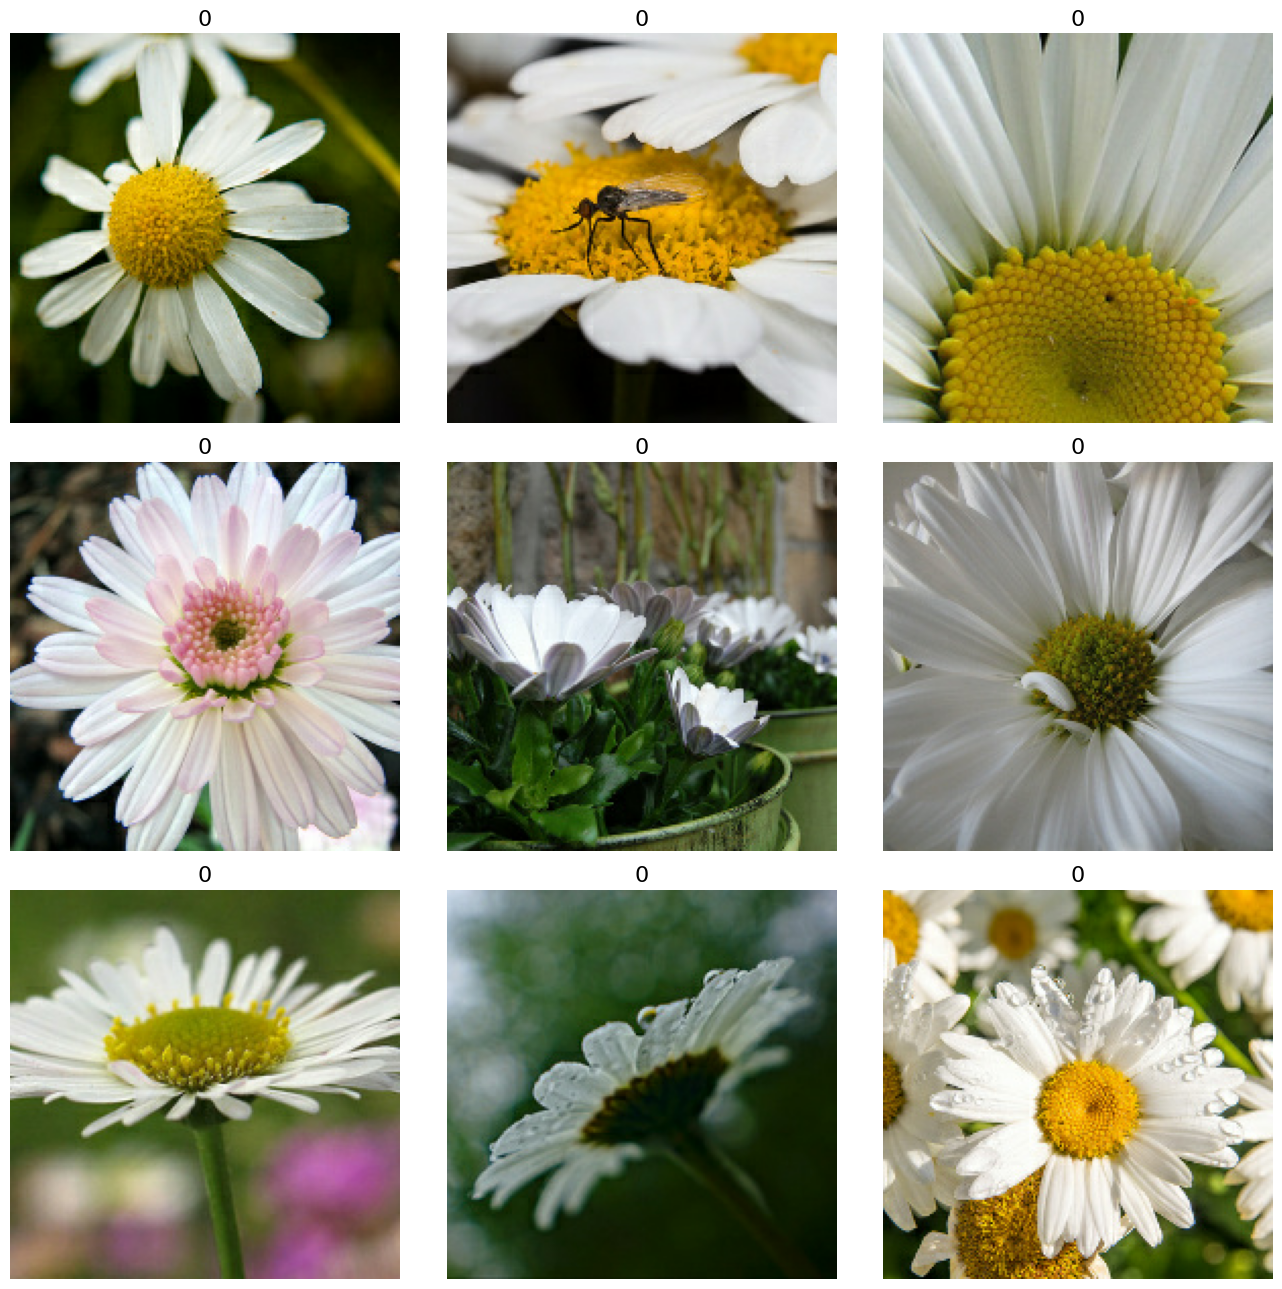

In [ ]:
### CODING TASK ###

import tensorflow as tf
import matplotlib.pyplot as plt

GCS_OUTPUT = 'gs://bd-coursework-zeynepdagci-storage/flowers-tfrecords/'
filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")

dataset = load_dataset(filenames)
display_9_images_from_dataset(dataset)

ii) Write your code above into a file using the *cell magic* `%%writefile spark_write_tfrec.py` at the beginning of the file. Then, run the file  locally in Spark.



In [50]:
### CODING TASK ###

%%writefile spark_write_tfrec.py

import pyspark
import os
import math
import numpy as np
import tensorflow as tf
import time

GCS_PATTERN = 'gs://cloud-samples-data/ai-platform/flowers_tfrec/*/*.jpg'
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
PARTITIONS = 16
SAMPLING_FACTOR = 0.02
TARGET_SIZE = (192, 192)
GCS_OUTPUT = 'gs://bd-coursework-zeynepdagci-storage/flowers-tfrecords/'

# spark context
sc = pyspark.SparkContext.getOrCreate()
print(sc)

# Mapping functions are adapted to Spark
def decode_jpeg_and_label(filepath):
    # extracts the image data and creates a class label, based on the filepath
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(image):
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]),
                    lambda: tf.image.resize(image, [w*th/h, h*th/h]))
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image

def recompress_image(image):
    image = tf.cast(image, tf.uint8)
    return tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)

def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def to_tfrecord(tfrec_filewriter, img_bytes, label): # Create tf data records
    class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
    one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
    feature = {
        "image": _bytestring_feature([img_bytes]), # one image in the list
        "class": _int_feature([class_num]) #,      # one class in the list
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecords(index, iterator):
  filename = f"{GCS_OUTPUT}{index:02d}.tfrec"
  with tf.io.TFRecordWriter(filename) as out_file:
    for filepath in iterator:
      file = tf.io.read_file(filepath)
      image = tf.image.decode_jpeg(file, channels=3)
      image, label = decode_jpeg_and_label(filepath)
      image = resize_and_crop_image(image)
      image_bytes = recompress_image(image).numpy()
      label = tf.strings.split(filepath, '/')[-2].numpy()
      example = to_tfrecord(out_file, image_bytes, label)
      out_file.write(example.SerializeToString())
  return [filename]

filepaths = tf.io.gfile.glob(GCS_PATTERN)

###   Default Partitions Version   ###
# Task 1a & 1b - Default partitions (2) is used which is the straightforward version
print("====== Default Partitions Version =======")
imageRDD = sc.parallelize(filepaths)
sampled_imageRDD = imageRDD.sample(False, SAMPLING_FACTOR, seed=42)  # 2% sample
start = time.time()
tfrecord_files = sampled_imageRDD.mapPartitionsWithIndex(write_tfrecords).collect()
print("Elapsed:", time.time() - start)
print("TFRecord files:")
for file in tfrecord_files:
    print(file)


### TASK 1d ###
print("====== 16 Partitions Version =======")
# Parallelisation is improved by using second parameter, PARTITIONS (16)
imageRDD_partitioned = sc.parallelize(filepaths, PARTITIONS)
sampled_imageRDD_partitioned = imageRDD_partitioned.sample(False, SAMPLING_FACTOR, seed=42)  # 2% sample

start = time.time()
tfrecord_files = sampled_imageRDD_partitioned.mapPartitionsWithIndex(write_tfrecords).collect()
print("Elapsed:", time.time() - start)

print("TFRecord files:")
for file in tfrecord_files:
    print(file)

Writing spark_write_tfrec.py


In [53]:
%run spark_write_tfrec.py

<SparkContext master=local[*] appName=pyspark-shell>
====== Default Partitions Version =======
Elapsed: 24.044904232025146
TFRecord files:
gs://bd-coursework-zeynepdagci-storage/flowers-tfrecords/00.tfrec
gs://bd-coursework-zeynepdagci-storage/flowers-tfrecords/01.tfrec
====== 16 Partitions Version =======
Elapsed: 30.733308792114258
TFRecord files:
gs://bd-coursework-zeynepdagci-storage/flowers-tfrecords/00.tfrec
gs://bd-coursework-zeynepdagci-storage/flowers-tfrecords/01.tfrec
gs://bd-coursework-zeynepdagci-storage/flowers-tfrecords/02.tfrec
gs://bd-coursework-zeynepdagci-storage/flowers-tfrecords/03.tfrec
gs://bd-coursework-zeynepdagci-storage/flowers-tfrecords/04.tfrec
gs://bd-coursework-zeynepdagci-storage/flowers-tfrecords/05.tfrec
gs://bd-coursework-zeynepdagci-storage/flowers-tfrecords/06.tfrec
gs://bd-coursework-zeynepdagci-storage/flowers-tfrecords/07.tfrec
gs://bd-coursework-zeynepdagci-storage/flowers-tfrecords/08.tfrec
gs://bd-coursework-zeynepdagci-storage/flowers-tfrecor

### 1c) Set up a cluster and run the script. (6%)

Following the example from the labs, set up a cluster to run PySpark jobs in the cloud. You need to set up so that TensorFlow is installed on all nodes in the cluster.  


#### i) Single machine cluster
Set up a cluster with a single machine using the maximal SSD size (100) and 8 vCPUs.

Enable **package installation** by passing a flag `--initialization-actions` with argument `gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh` (this is a public script that will read metadata to determine which packages to install).
Then, the **packages are specified** by providing a `--metadata` flag with the argument `PIP_PACKAGES=tensorflow==2.4.0`.

Note: consider using `PIP_PACKAGES="tensorflow numpy"` or `PIP_PACKAGES=tensorflow` in case an older version of tensorflow is causing issues.

When the cluster is running, run your script to check that it works and keep the output cell output. (3%)


In [ ]:
### CODING TASK ###

CLUSTER = f"{PROJECT}-single-cluster"

# This region is chosen instead of europe-west2 due to the following error:
# "Error Message: The zone 'projects/bd-coursework-zeynepdagci/zones/europe-west2-a' does not
# have enough resources available to fulfill the request.  Try a different zone, or try again later."
REGION = "us-east1"

!gcloud dataproc clusters create $CLUSTER \
  --region=$REGION \
  --single-node \
  --master-machine-type=n1-standard-8 \
  --master-boot-disk-type=pd-ssd \
  --master-boot-disk-size=100 \
  --image-version=1.5-ubuntu18 \
  --initialization-actions=gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
  --metadata=PIP_PACKAGES="tensorflow==2.4.1 numpy==1.19.5 protobuf==3.20.3" # these are chosen to fix errors during the cluster creation

Waiting on operation [projects/bd-coursework-zeynepdagci/regions/us-east1/operations/164aa728-a0a6-3367-b8b2-0df9975a9c5c].

Created [https://dataproc.googleapis.com/v1/projects/bd-coursework-zeynepdagci/regions/us-east1/clusters/bd-coursework-zeynepdagci-single-cluster] Cluster placed in zone [us-east1-c].


Run the script in the cloud and test the output.

In [ ]:
### CODING TASK ###

!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region=$REGION ./spark_write_tfrec.py

Job [7959941869644b4a8cf706a652002eeb] submitted.
Waiting for job output...
2025-04-30 23:51:13.694388: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2025-04-30 23:51:13.694431: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
25/04/30 23:51:16 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
25/04/30 23:51:16 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
25/04/30 23:51:17 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
25/04/30 23:51:17 INFO org.spark_project.jetty.util.log: Logging initialized @6046ms to org.spark_project.jetty.util.log.Slf4jLog
25/04/30 23:51:17 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built: unknown; git: unknown; 

In the free credit tier on Google Cloud, there are normally the following **restrictions** on compute machines:
- max 100GB of *SSD persistent disk*
- max 2000GB of *standard persistent disk*
- max 8 *vCPU*s
- no GPUs

See [here](https://cloud.google.com/free/docs/gcp-free-tier#free-trial) for details
The **disks are virtual** disks, where **I/O speed is limited in proportion to the size**, so we should allocate them evenly.
This has mainly an effect on the **time the cluster needs to start**, as we are reading the data mainly from the bucket and we are not writing much to disk at all.  


#### ii) Maximal cluster
Use the **largest possible cluster** within these constraints, i.e. **1 master and 7 worker nodes**.
Each of them with 1 (virtual) CPU.
The master should get the full *SSD* capacity and the 7 worker nodes should get equal shares of the *standard* disk capacity to maximise throughput.

Once the cluster is running, test your script. (3%)

In [20]:
### CODING TASK ###

# Free credit tier on Google Cloud offers max 2000GB of standard persistent disk therefore,
# 285GB is chosen for each of the worker nodes 7 × 285GB = 1995GB (under 2000GB limit)
# So, 7 worker nodes get equal shares of the standard disk capacity

CLUSTER = f"{PROJECT}-maximal-cluster"

# This region is chosen instead of europe-west2 due to the following error:
# "Error Message: The zone 'projects/bd-coursework-zeynepdagci/zones/europe-west2-a' does not
# have enough resources available to fulfill the request.  Try a different zone, or try again later."
REGION = "us-east1"

!gcloud dataproc clusters create $CLUSTER \
  --region=$REGION \
  --image-version=1.5-ubuntu18 \
  --master-machine-type=n1-standard-1 \
  --master-boot-disk-type=pd-ssd \
  --master-boot-disk-size=100 \
  --num-workers=7 \
  --worker-machine-type=n1-standard-1 \
  --worker-boot-disk-type=pd-standard \
  --worker-boot-disk-size=285  \
  --max-idle=3600s \
  --initialization-actions=gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
  --metadata=PIP_PACKAGES="tensorflow==2.4.1 numpy==1.19.5 protobuf==3.20.3" # these are chosen to fix errors during the cluster creation

Waiting on operation [projects/bd-coursework-zeynepdagci/regions/us-east1/operations/e196746c-6264-3bdb-8bf3-1b3cadc17794].

Created [https://dataproc.googleapis.com/v1/projects/bd-coursework-zeynepdagci/regions/us-east1/clusters/bd-coursework-zeynepdagci-maximal-cluster] Cluster placed in zone [us-east1-c].


In [ ]:
### CODING TASK ###

!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region=$REGION ./spark_write_tfrec.py

Job [8a95ce8dac3c4faba9c8c1c04e577e29] submitted.
Waiting for job output...
2025-05-01 00:04:13.175788: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2025-05-01 00:04:13.176092: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
25/05/01 00:04:20 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
25/05/01 00:04:20 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
25/05/01 00:04:20 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
25/05/01 00:04:21 INFO org.spark_project.jetty.util.log: Logging initialized @15470ms to org.spark_project.jetty.util.log.Slf4jLog
25/05/01 00:04:21 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built: unknown; git: unknown;

### 1d)	Optimisation, experiments, and discussion (17%)

i) Improve parallelisation

If you implemented a straightfoward version, you will
**probably** observe that **all the computation** is done on only **two nodes**.
This can be adressed by using the **second parameter** in the initial call to **parallelize**.
Make the **suitable change** in the code you have written above and mark it up in comments as `### TASK 1d ###`.

Demonstrate the difference in cluster utilisation before and after the change based on different parameter values with **screenshots from Google Cloud** and measure the **difference in the processing time**. (6%)

ii) Experiment with cluster configurations.

In addition to the experiments above (using 8 VMs),test your program with 4 machines with double the resources each (2 vCPUs, memory, disk) and 1 machine with eightfold resources.
Discuss the results in terms of disk I/O and network bandwidth allocation in the cloud. (7%)

iii) Explain the difference between this use of Spark and most standard applications like e.g. in our labs in terms of where the data is stored. What kind of parallelisation approach is used here? (4%)

Write the code below and your answers in the report.


In [ ]:
# i) Improve parallelisation

# Suitable change in the code is written above in Task 1a and marked it up in comments

In [ ]:
# ii) Experiment with cluster configurations
# 4 machines with double the resources each (2 vCPUs, memory, disk)

CLUSTER = f"{PROJECT}-4x2-cluster"

# This region is chosen instead of europe-west2 due to the following error:
# "Error Message: The zone 'projects/bd-coursework-zeynepdagci/zones/europe-west2-a' does not
# have enough resources available to fulfill the request.  Try a different zone, or try again later."
REGION = "us-east1"

# master-boot-disk-size=100 because of the free credit tier (max 100GB of SSD persistent disk)
# worker-boot-disk-size=285 is doubled and now worker-boot-disk-size=570 (570 x 3 = 1710 still under 2000GB limit)

# 2 vCPU Dataproc cluster with 4 nodes is created
!gcloud dataproc clusters create $CLUSTER \
  --region=$REGION \
  --image-version=1.5-ubuntu18 \
  --master-machine-type=n1-standard-2 \
  --master-boot-disk-type=pd-ssd \
  --master-boot-disk-size=100 \
  --num-workers=3 \
  --worker-machine-type=n1-standard-2 \
  --worker-boot-disk-type=pd-standard \
  --worker-boot-disk-size=570 \
  --max-idle=3600s \
  --initialization-actions=gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
  --metadata=PIP_PACKAGES="tensorflow==2.4.1 numpy==1.19.5 protobuf==3.20.3"

!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region=$REGION ./spark_write_tfrec.py

Waiting on operation [projects/bd-coursework-zeynepdagci/regions/us-east1/operations/d9a6f7bc-d71d-3257-8f26-05e8d310091e].

Created [https://dataproc.googleapis.com/v1/projects/bd-coursework-zeynepdagci/regions/us-east1/clusters/bd-coursework-zeynepdagci-4x2-cluster] Cluster placed in zone [us-east1-c].
Job [0cdfbd02e883474aa3a19b25587ac92e] submitted.
Waiting for job output...
2025-04-30 22:54:54.412477: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2025-04-30 22:54:54.412521: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
25/04/30 22:54:57 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
25/04/30 22:54:58 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
25/04/30 22:54:58 INFO o

In [ ]:
# ii) Experiment with cluster configurations
# 1 machine with eightfold resources

CLUSTER = f"{PROJECT}-1x8-cluster"

# This region is chosen instead of europe-west2 due to the following error:
# "Error Message: The zone 'projects/bd-coursework-zeynepdagci/zones/europe-west2-a' does not
# have enough resources available to fulfill the request.  Try a different zone, or try again later."
REGION = "us-east1"

# master-boot-disk-size=100 because of the free credit tier (max 100GB of SSD persistent disk)

# 8 vCPU Dataproc cluster with single node is created
!gcloud dataproc clusters create $CLUSTER \
  --region=$REGION \
  --single-node \
  --master-machine-type=n1-standard-8 \
  --master-boot-disk-type=pd-ssd \
  --master-boot-disk-size=100 \
  --image-version=1.5-ubuntu18 \
  --initialization-actions=gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
  --metadata=PIP_PACKAGES="tensorflow==2.4.1 numpy==1.19.5 protobuf==3.20.3"

!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region=$REGION ./spark_write_tfrec.py

Waiting on operation [projects/bd-coursework-zeynepdagci/regions/us-east1/operations/db73f5de-5a78-376f-aefd-75c14a70bcf0].

Created [https://dataproc.googleapis.com/v1/projects/bd-coursework-zeynepdagci/regions/us-east1/clusters/bd-coursework-zeynepdagci-1x8-cluster] Cluster placed in zone [us-east1-c].
Job [ea41b332a86d43a5bb29a8b98445581a] submitted.
Waiting for job output...
2025-04-30 22:27:35.939467: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2025-04-30 22:27:35.939511: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
25/04/30 22:27:39 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
25/04/30 22:27:39 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
25/04/30 22:27:39 INFO o

In [ ]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region=$REGION ./spark_write_tfrec.py

Job [012322cc27ef440bb2e957262f7f6762] submitted.
Waiting for job output...
2025-04-30 20:47:00.247561: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2025-04-30 20:47:00.247605: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
25/04/30 20:47:02 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
25/04/30 20:47:02 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
25/04/30 20:47:02 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
25/04/30 20:47:02 INFO org.spark_project.jetty.util.log: Logging initialized @4926ms to org.spark_project.jetty.util.log.Slf4jLog
25/04/30 20:47:02 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built: unknown; git: unknown; 

In [ ]:
# iii) Explain the difference between this use of Spark
# and most standard applications like e.g. in our labs in terms of
# where the data is stored. What kind of parallelisation approach is used here? (4%)

# This part is explained in the report

# Section 2: Speed tests

We have seen that **reading from the pre-processed TFRecord files** is **faster** than reading individual image files and decoding on the fly.
This task is about **measuring this effect** and **parallelizing the tests with PySpark**.

## 2.1 Speed test implementation

Here is **code for time measurement** to determine the **throughput in images per second**.
It doesn't render the images but extracts and prints some basic information in order to make sure the image data are read.
We write the information to the null device for longer measurements `null_file=open("/dev/null", mode='w')`.
That way it will not clutter our cell output.

We use batches ( `dset2 = dset1.batch(batch_size)` ) and select a number of batches with (`dset3 = dset2.take(batch_number)`).
Then we  use the `time.time()` to take the **time measurement** and take it multiple times, reading from the same dataset to see if reading speed changes with mutiple readings.

We then **vary** the size of the batch (`batch_size`) and the number of batches (`batch_number`) and **store the results for different values**.
Store also the **results for each repetition** over the same dataset (repeat 2 or 3 times).

The speed test should be combined in a **function** `time_configs()` that takes a configuration, i.e. a dataset and arrays of `batch_sizes`, `batch_numbers`, and  `repetitions` (an array of integers starting from 1), as **arguments** and runs the time measurement for each combination of batch_size and batch_number for the requested number of repetitions.

In [54]:
# Here are some useful values for testing your code, use higher values later for actually testing throughput
batch_sizes = [2,4]
batch_numbers = [3,6]
repetitions = [1]

def time_configs(dataset, batch_sizes, batch_numbers, repetitions):
    dims = [len(batch_sizes),len(batch_numbers),len(repetitions)]
    print(dims)
    results = np.zeros(dims)
    params = np.zeros(dims + [3])
    print( results.shape )
    with open("/dev/null",mode='w') as null_file: # for printing the output without showing it
        tt = time.time() # for overall time taking
        for bsi,bs in enumerate(batch_sizes):
            for dsi, ds in enumerate(batch_numbers):
                batched_dataset = dataset.batch(bs)
                timing_set = batched_dataset.take(ds)
                for ri,rep in enumerate(repetitions):
                    print("bs: {}, ds: {}, rep: {}".format(bs,ds,rep))
                    t0 = time.time()
                    for image, label in timing_set:
                        #print("Image batch shape {}".format(image.numpy().shape),
                        print("Image batch shape {}, {})".format(image.numpy().shape,
                            [str(lbl) for lbl in label.numpy()]), null_file)
                    td = time.time() - t0 # duration for reading images
                    results[bsi,dsi,ri] = ( bs * ds) / td
                    params[bsi,dsi,ri] = [ bs, ds, rep ]
    print("total time: "+str(time.time()-tt))
    return results, params

**Let's try this function** with a **small number** of configurations of batch_sizes batch_numbers and repetions, so that we get a set of parameter combinations and corresponding reading speeds.
Try reading from the image files (dataset4) and the TFRecord files (datasetTfrec).

In [ ]:
[res,par] = time_configs(dataset4, batch_sizes, batch_numbers, repetitions)
print(res)
print(par)

print("=============")

[res,par] = time_configs(datasetTfrec, batch_sizes, batch_numbers, repetitions)
print(res)
print(par)

[2, 2, 1]
(2, 2, 1)
bs: 2, ds: 3, rep: 1
Image batch shape (2,), ["b'roses'", "b'sunflowers'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='utf-8'>
Image batch shape (2,), ["b'dandelion'", "b'sunflowers'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='utf-8'>
Image batch shape (2,), ["b'dandelion'", "b'tulips'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='utf-8'>
bs: 2, ds: 6, rep: 1
Image batch shape (2,), ["b'daisy'", "b'tulips'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='utf-8'>
Image batch shape (2,), ["b'roses'", "b'tulips'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='utf-8'>
Image batch shape (2,), ["b'sunflowers'", "b'tulips'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='utf-8'>
Image batch shape (2,), ["b'roses'", "b'dandelion'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='utf-8'>
Image batch shape (2,), ["b'daisy'", "b'dandelion'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='utf-8'>

## Task 2: Parallelising the speed test with Spark in the cloud. (36%)

As an exercise in **Spark programming and optimisation** as well as **performance analysis**, we will now implement the **speed test** with multiple parameters in parallel with Spark.
Runing multiple tests in parallel would **not be a useful approach on a single machine, but it can be in the cloud** (you will be asked to reason about this later).


### 2a) Create the script (14%)
Your task is now to **port the speed test above to Spark** for running it in the cloud in Dataproc.
**Adapt the speed testing** as a Spark program that performs the same actions as above, but **with Spark RDDs in a distributed way**.
The distribution should be such that **each parameter combination (except repetition)** is processed in a separate Spark task.

More specifically:
*   i) combine the previous cells to have the code to create a dataset and create a list of parameter combinations in an RDD (2%)
*   ii) get a Spark context and  create the dataset and run timing test for each combination in parallel (2%)
*   iii) transform the resulting RDD to the structure \( parameter_combination, images_per_second \) and save these values in an array (2%)
*   iv) create an RDD with all results for each parameter as (parameter_value,images_per_second) and collect the result for each parameter  (2%)
*   v) create an RDD with the average reading speeds for each parameter value and collect the results. Keep associativity in mind when implementing the average. (3%)
*   vi) write the results to a pickle file in your bucket (2%)
*   vii) Write your code it into a file using the *cell magic* `%%writefile spark_job.py` (1%)


**Important:** The task here is not to parallelize the pre-processing, but to run multiple speed tests in parallel using Spark.


In [17]:
### CODING TASK

%%writefile spark_job.py

import pyspark
import tensorflow as tf
import numpy as np
import time
import pickle
import datetime
import subprocess

GCS_PATTERN = 'gs://cloud-samples-data/ai-platform/flowers_tfrec/*/*.jpg' # glob  pattern for input files
TARGET_SIZE = [192, 192] # target resolution for the images
GCS_OUTPUT = 'gs://cloud-samples-data/ai-platform/flowers_tfrec/tfrecords-jpeg-192x192-2/' # ready-made pre-processed data

# Map functions
def decode_jpeg_and_label(filepath):
    # extracts the image data and creates a class label, based on the filepath
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(image, label):
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image
    # so that it fills the TARGET_SIZE entirely with no black bars
    # and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_image(image, label):
    # this reduces the amount of data, but takes some time
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label

# TFRecord files are read
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, features)
    image   = tf.image.decode_jpeg(example['image'], channels=3)
    image   = tf.reshape(image, [192, 192, 3])
    label   = example['class']
    return image, label

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

def time_configs(dataset, batch_sizes, batch_numbers, repetitions):
    dims = [len(batch_sizes),len(batch_numbers),len(repetitions)]
    print(dims)
    results = np.zeros(dims)
    params = np.zeros(dims + [3])
    print(results.shape)
    with open("/dev/null",mode='w') as null_file: # for printing the output without showing it
        tt = time.time() # for overall time taking
        for bsi,bs in enumerate(batch_sizes):
            for dsi, ds in enumerate(batch_numbers):
                batched_dataset = dataset.batch(bs)
                timing_set = batched_dataset.take(ds)
                for ri,rep in enumerate(repetitions):
                    print("bs: {}, ds: {}, rep: {}".format(bs,ds,rep))
                    t0 = time.time()
                    for image, label in timing_set:
                        print("Image batch shape {}, {})".format(image.numpy().shape,
                            [str(lbl) for lbl in label.numpy()]), null_file)
                    td = time.time() - t0 # duration for reading images
                    results[bsi,dsi,ri] = ( bs * ds) / td
                    params[bsi,dsi,ri] = [ bs, ds, rep ]
    print("total time: "+str(time.time()-tt))
    return results, params


def run_speed_test(bs_ds):
    bs, ds = bs_ds # a tuple bs_ds (batch_size, batch_number)

    #JPEG pipeline is rebuilt
    jpeg_files = tf.data.Dataset.list_files(GCS_PATTERN)
    jpeg_files_decoded = jpeg_files.map(decode_jpeg_and_label)
    jpeg_files_resized = jpeg_files_decoded.map(resize_and_crop_image)
    image_files = jpeg_files_resized.map(recompress_image)

    # TFRecord pipeline is rebuilt
    filenames = tf.io.gfile.glob(GCS_OUTPUT + '*.tfrec')
    datasetTfrec = load_dataset(filenames)

    # time_configs is called for each (bs, ds)
    res_jpeg, params  = time_configs(image_files, [bs], [ds], repetitions)
    res_tfrec, params = time_configs(datasetTfrec, [bs], [ds], repetitions)

    # res_jpeg and res_tfrec are flatten to list
    jpeg_list  = res_jpeg.flatten().tolist()
    tfrec_list = res_tfrec.flatten().tolist()

    # a list is returned
    out = []
    for index, rep in enumerate(repetitions):
        out.append(((bs, ds, rep), jpeg_list[index], tfrec_list[index]))
    return out

# Average images/sec per parameter is computed
def sum_count_avg(rdd):
    pairs = rdd.map(lambda pair: (pair[0], (pair[1], 1))) # each (key, value) pair is turned into (key, (value,1))
    sums = pairs.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1])) # the sum of values and counts per key
    averages = sums.map(lambda pair: (pair[0], pair[1][0] / pair[1][1])) # sum/count is computed for average
    return dict(averages.collect())


sc = pyspark.SparkContext.getOrCreate()

batch_sizes   = [4, 8, 16, 32, 64]
batch_numbers = [10, 20, 50, 100, 200]
repetitions   = [1, 2]

# all (batch_size, batch_number) pairs are built
param_combinations = [(bs, ds) for bs in batch_sizes for ds in batch_numbers]

# each pair of (bs, ds) is parallelized so that each can run as a separate Spark task
params_rdd = sc.parallelize(param_combinations, numSlices=len(param_combinations))
print(params_rdd.count(), " tasks to run:", params_rdd.collect())

rdd = params_rdd.flatMap(run_speed_test)

# Straightforward version (without caching)
start_notcached = time.time() # time is started for not cached version
results = rdd.collect()
notcached_time = time.time() - start_notcached # time is measured for not cached version

print("Results of not cached version:") # results are printed for not cached version as (parameters, jpeg, tfrecord)
for rec in results:
    print(rec)

pairs_rdd = rdd.flatMap(lambda x: [
    (("jpeg", "bs",  x[0][0]), x[1]),
    (("jpeg", "ds",  x[0][1]), x[1]),
    (("tfrec","bs",  x[0][0]), x[2]),
    (("tfrec","ds",  x[0][1]), x[2])
])

averages = sum_count_avg(pairs_rdd)

print("Average images/sec by parameter")
for param, avg in sorted(averages.items()):
    print(f"{param}: {avg:.2f}")


# results and averages are saved to a timestamped local pickle file,
# and then copied to the Google Cloud Storage
output_obj = {
    'results': results,
    'averages':    averages
}
timestamp  = datetime.datetime.now().strftime("%y%m%d-%H%M")
source = f"/tmp/speed_results_{timestamp}.pkl"
with open(source, "wb") as f:
    pickle.dump(output_obj, f)

# Pickle file is copied to the bucket
destination = f"gs://bd-coursework-zeynepdagci-storage/speed_results_{timestamp}.pkl"
subprocess.run(["gsutil", "cp", source, destination], check=True
)

print(f"Saved results locally to {source}, and copied to {destination}")

print("=============")

### TASK 2c ###
# to avoid recomputing run_speed_test, cache() is implemented
# speed-up occurs due to the use of cache because it re-uses from the memory
cached_rdd = rdd.cache() # rdd is cached
start_cached = time.time() # time is started for cached version
cached_results = cached_rdd.collect() # every task is run once
cached_time = time.time() - start_cached # time is measured for cached version

print("Results of cached version:") # results are printed for cached version as (parameters, jpeg, tfrecord)
for rec in cached_results:
    print(rec)

# speed-up is shown while comparing the not cached and cached versions
print(f"No‐cache run: {notcached_time:.1f}s, cache run: {cached_time:.1f}s ({notcached_time/cached_time:.1f}× speedup)")

pairs_rdd = cached_rdd.flatMap(lambda x: [
    (("jpeg", "bs",  x[0][0]), x[1]),
    (("jpeg", "ds",  x[0][1]), x[1]),
    (("tfrec","bs",  x[0][0]), x[2]),
    (("tfrec","ds",  x[0][1]), x[2])
])

averages = sum_count_avg(pairs_rdd)

print("Cached Version - Average images/sec by parameter")
for param, avg in sorted(averages.items()):
    print(f"{param}: {avg:.2f}")


Writing spark_job.py


### 2b) Testing the code and collecting results (4%)

i) First, test locally with `%run`.

It is useful to create a **new filename argument**, so that old results don't get overwritten.

You can for instance use `datetime.datetime.now().strftime("%y%m%d-%H%M")` to get a string with the current date and time and use that in the file name.

In [18]:
### CODING TASK
%run spark_job.py

25  tasks to run: [(4, 10), (4, 20), (4, 50), (4, 100), (4, 200), (8, 10), (8, 20), (8, 50), (8, 100), (8, 200), (16, 10), (16, 20), (16, 50), (16, 100), (16, 200), (32, 10), (32, 20), (32, 50), (32, 100), (32, 200), (64, 10), (64, 20), (64, 50), (64, 100), (64, 200)]
Results of not cached version:
((4, 10, 1), 4.3587921762337505, 15.603265325102594)
((4, 10, 2), 4.6174822833886635, 30.963899293415018)
((4, 20, 1), 4.300466774195322, 31.17427892175212)
((4, 20, 2), 4.582403379676321, 58.65402680563242)
((4, 50, 1), 4.526015982951472, 220.80263891093333)
((4, 50, 2), 4.581931636340834, 131.26639733029634)
((4, 100, 1), 5.056502134981606, 118.94483106747658)
((4, 100, 2), 5.067189793742569, 139.28557226106713)
((4, 200, 1), 5.11055653589889, 124.13264108900296)
((4, 200, 2), 5.648298836995162, 132.56444783750558)
((8, 10, 1), 3.8218866128931235, 62.31727617170256)
((8, 10, 2), 4.45956032017939, 62.041615087711186)
((8, 20, 1), 6.142865403311753, 109.90167473925136)
((8, 20, 2), 5.9403922

<Figure size 640x480 with 0 Axes>

ii) Cloud

If  you have a cluster running, you can run the  speed test job in the cloud.

While you run this job, switch to the Dataproc web page and take **screenshots of the CPU and network load** over time. They are displayed with some delay, so you may need to wait a little. These images will be useful in the next task. Again, don't use the SCREENSHOT function that Google provides, but just take a picture of the graphs you see for the VMs.


In [21]:
### CODING TASK ###

# after the cluster creation in task 1c - part ii

CLUSTER = f"{PROJECT}-maximal-cluster"

# This region is chosen instead of europe-west2 due to the following error:
# "Error Message: The zone 'projects/bd-coursework-zeynepdagci/zones/europe-west2-a' does not
# have enough resources available to fulfill the request.  Try a different zone, or try again later."
REGION = "us-east1"


!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region=$REGION ./spark_job.py


Job [f64cfb0eae294d3f9474e52336782606] submitted.
Waiting for job output...
2025-05-02 00:57:12.629381: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2025-05-02 00:57:12.629686: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
25/05/02 00:57:17 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
25/05/02 00:57:17 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
25/05/02 00:57:18 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
25/05/02 00:57:18 INFO org.spark_project.jetty.util.log: Logging initialized @11657ms to org.spark_project.jetty.util.log.Slf4jLog
25/05/02 00:57:18 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built: unknown; git: unknown;

### 2c) Improve efficiency (6%)

If you implemented a straightfoward version of 2a), you will **probably have an inefficiency** in your code.

Because we are reading multiple times from an RDD to read the values for the different parameters and their averages, caching existing results is important. Explain **where in the process caching can help**, and **add a call to `RDD.cache()`** to your code, if you haven't yet. Measure the the effect of using caching or not using it.

Make the **suitable change** in the code you have written above and mark them up in comments as `### TASK 2c ###`.

Explain in your report what the **reasons for this change** are and **demonstrate and interpret its effect**

In [ ]:
# Suitable changes in the code have been made and it is explained in the report.

### 2d) Retrieve, analyse and discuss the output (12%)

Run the tests over a wide range of different paramters and list the results in a table.

Perform a **linear regression** (e.g. using scikit-learn) over **the values for each parameter** and for the **two cases** (reading from image files/reading TFRecord files).
List a **table** with the output and interpret the results in terms of the effects of overall.  
Also, **plot** the output values, the averages per parameter value and the regression lines for each parameter and for the product of batch_size and batch_number

Discuss the **implications** of this result for **applications** like large-scale machine learning.
Keep in mind that cloud data may be stored in distant physical locations.
Use the numbers provided in the PDF latency-numbers document available on Moodle or [here](https://gist.github.com/hellerbarde/2843375) for your arguments.

How is the **observed** behaviour **similar or different** from what you’d expect from a **single machine**? Why would cloud providers tie throughput to capacity of disk resources?

By **parallelising** the speed test we are making **assumptions** about the limits of the bucket reading speeds.
See [here](https://cloud.google.com/storage/docs/request-rate) for more information.
Discuss, **what we need to consider** in **speed tests** in parallel on the cloud, which bottlenecks we might be identifying, and how this relates to your results.

Discuss to what extent **linear modelling** reflects the **effects** we are observing.
Discuss what could be expected from a theoretical perspective and what can be useful in practice.
  
Write your **code below** and **include the output** in your submitted `ipynb` file. Provide the answer **text in your report**.

Copying gs://bd-coursework-zeynepdagci-storage/speed_results_250502-0145.pkl...
/ [1 files][  2.2 KiB/  2.2 KiB]                                                
Operation completed over 1 objects/2.2 KiB.                                      

======= Raw Results =======


bs   ds  rep       jpeg        tfrec
0    4   10    1   8.040205   197.226567
1    4   10    2   8.690689   222.501233
2    4   20    1   9.101575   424.146914
3    4   20    2   9.194240   416.857866
4    4   50    1   9.047941   647.750951
5    4   50    2   9.315417   578.820886
6    4  100    1   9.507472   622.893848
7    4  100    2   9.903692   705.959956
8    4  200    1   9.730544   657.157300
9    4  200    2   9.909798   710.748551
10   8   10    1   8.631747   327.065156
11   8   10    2   9.136626   383.189313
12   8   20    1   9.310249   644.869534
13   8   20    2   9.426487   602.112445
14   8   50    1   9.942191   775.460327
15   8   50    2  10.152846   755.613705
16   8  100    1   9.445345   638.367335
17   8  100    2   9.231427   659.622553
18   8  200    1   9.642711   687.920754
19   8  200    2   9.695945   762.879785
20  16   10    1   9.701730   625.164086
21  16   10    2   9.500050   618.683089
22  16   20    1   9.762898   649.121398
23  16   20    2   9.419220   678.437818
24  16   50    1   9.811002   727.016098
25  16   50    2   9.932981   759.842155
26  16  100    1  10.038287   846.969795
27  16  100    2  10.218512   844.884510
28  16  200    1   9.746789   642.660735
29  16  200    2   9.307070   760.123459
30  32   10    1   9.841999   633.581562
31  32   10    2  10.007137   697.262117
32  32   20    1   9.329784   733.252504
33  32   20    2   9.208135   755.295815
34  32   50    1   9.928820   845.037922
35  32   50    2   9.831585   855.642844
36  32  100    1   9.918325   755.769430
37  32  100    2   9.721227   840.504775
38  32  200    1  15.688006  1234.703501
39  32  200    2  15.703203  1387.528869
40  64   10    1   9.686867   752.989416
41  64   10    2   9.660385   813.665643
42  64   20    1  10.164862   832.332840
43  64   20    2  10.101051   839.880205
44  64   50    1   9.513570   828.908254
45  64   50    2   9.701002   843.659748
46  64  100    1  16.838562  1403.254053
47  64  100    2  17.084275  1449.131753
48  64  200    1  34.786657  3010.023276
49  64  200    2  35.146371  3040.458192


======= Average Results =======


file param  param_value     avg_rate
8    jpeg    bs            4     9.583145
17  tfrec    bs            4   534.886094
5   tfrec    bs            8   665.425586
0    jpeg    bs            8     9.773441
15   jpeg    ds           10     9.847909
7   tfrec    ds           10   556.847346
19   jpeg    bs           16    10.090046
4   tfrec    bs           16   742.836899
3   tfrec    ds           20   655.800080
14   jpeg    ds           20     9.702873
10  tfrec    bs           32   901.504480
18   jpeg    bs           32    11.321400
9   tfrec    ds           50   772.467275
12   jpeg    ds           50    10.074813
6    jpeg    bs           64    16.563468
1   tfrec    bs           64  1372.095451
2    jpeg    ds          100    11.350799
16  tfrec    ds          100   897.186503
13  tfrec    ds          200  1334.447306
11   jpeg    ds          200    16.355105

jpeg_avg    tfrec_avg
bs_ds                        
40      8.365447   209.863900
80      9.016047   387.814812
160     9.484629   622.707289
200     9.181679   613.285918
320     9.757813   664.600724
400     9.876550   714.981959
640     9.471293   763.800845
800     9.676849   692.125665
1280   10.132956   836.106522
1600    9.892644   807.222601
3200    9.651330   778.604400
6400   16.328512  1368.654544
12800  34.966514  3025.240734


======= Linear Regression =======


param  files       coef   intercept        r2   p-value
0     bs   jpeg   0.117334    8.217260  0.240748  0.000297
1     ds   jpeg   0.035104    8.459218  0.218318  0.000624
2  bs*ds   jpeg   0.001705    7.914433  0.855140  0.000000
3     bs  tfrec  13.813890  479.954550  0.348235  0.000006
4     ds  tfrec   3.710844  540.514897  0.254590  0.000187
5  bs*ds  tfrec   0.169357  503.334527  0.880964  0.000000

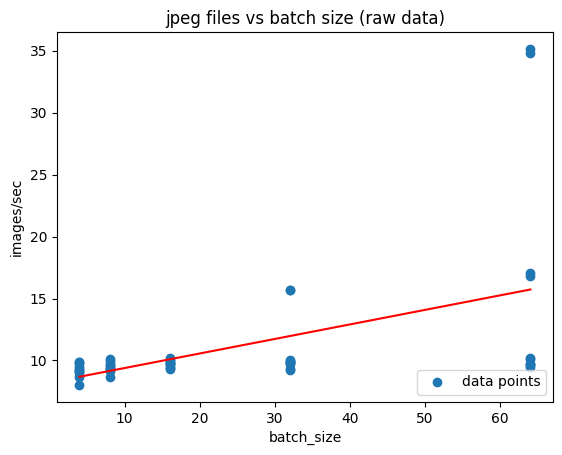

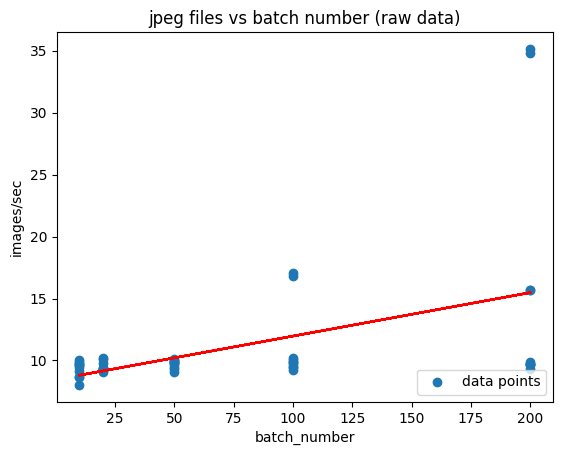

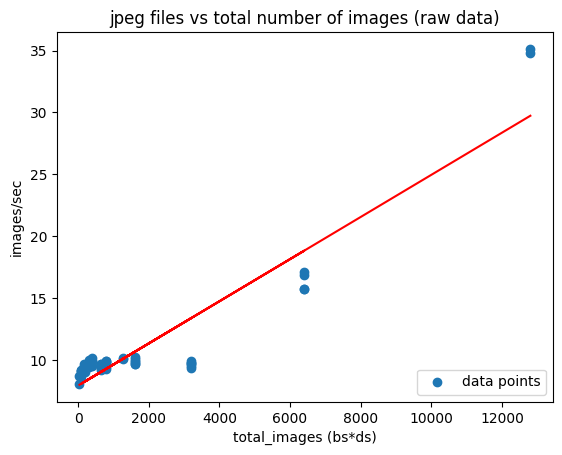

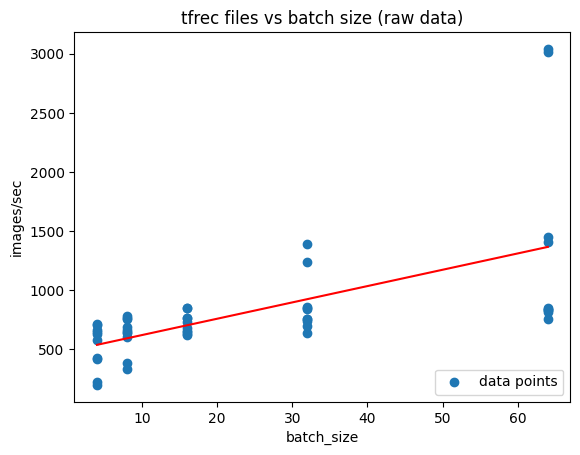

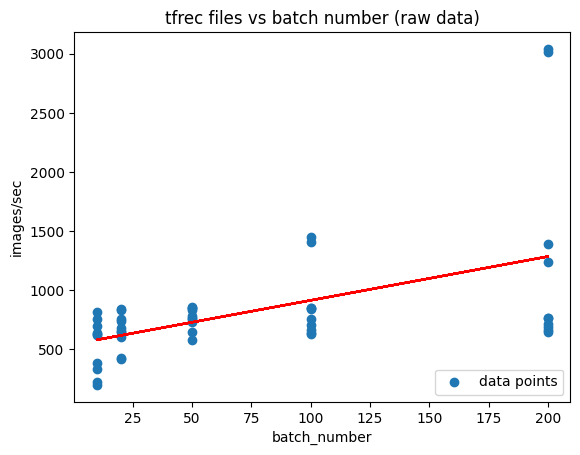

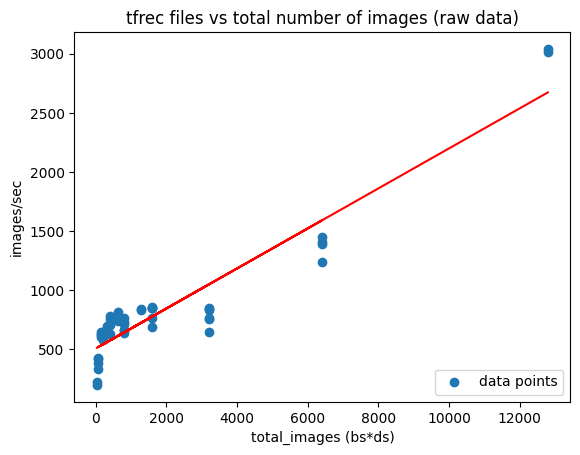

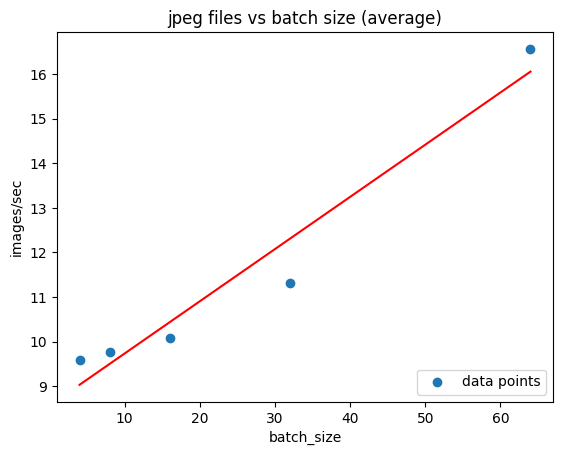

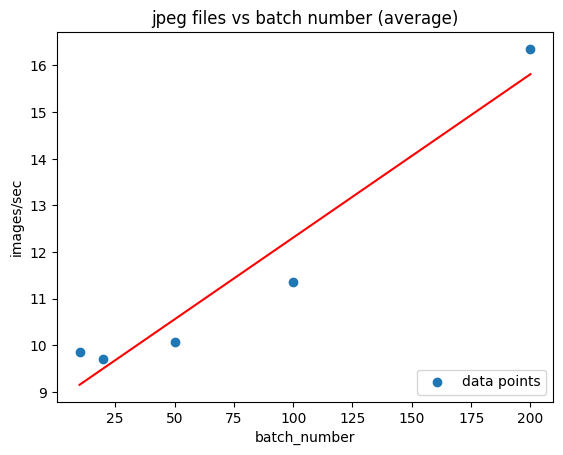

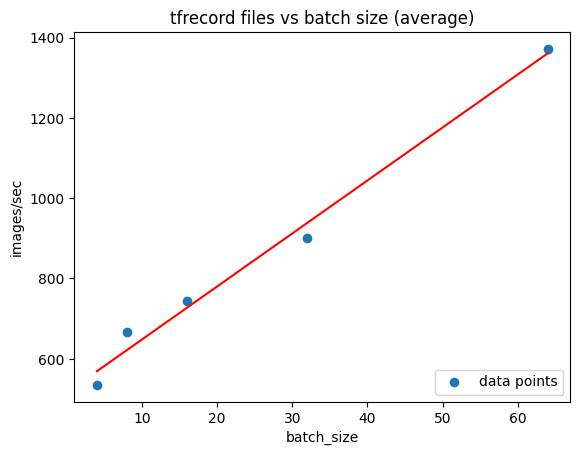

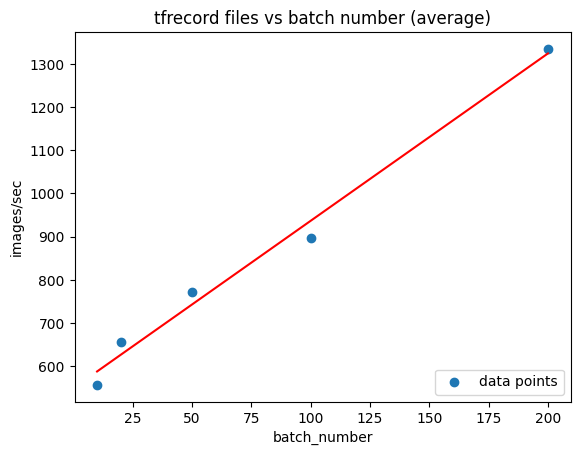

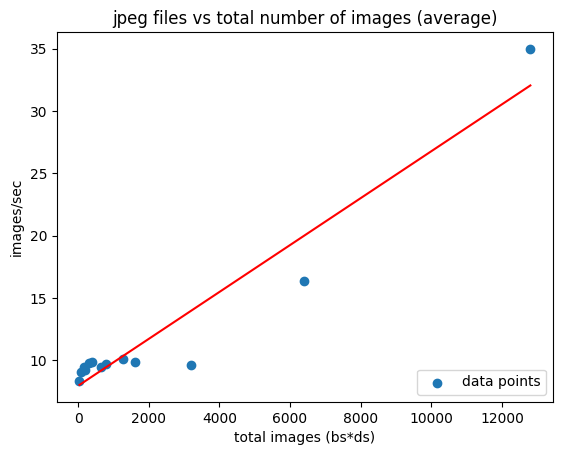

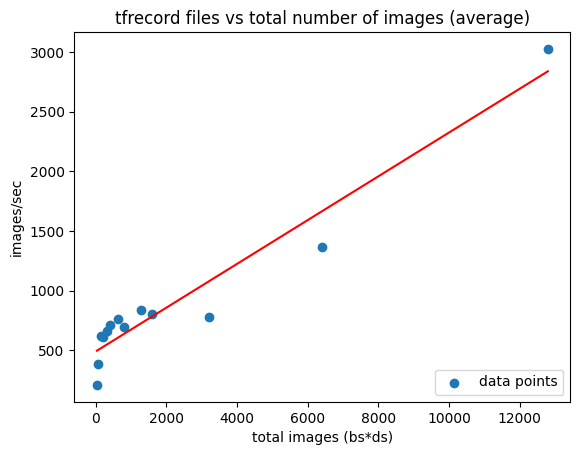

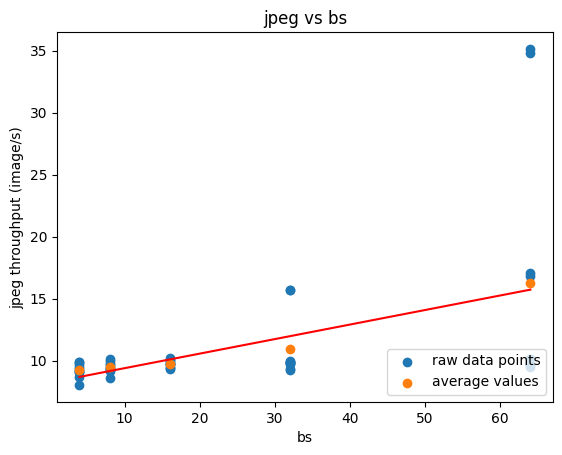

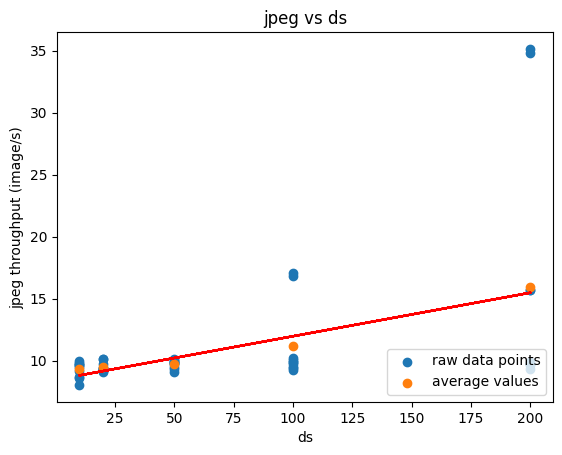

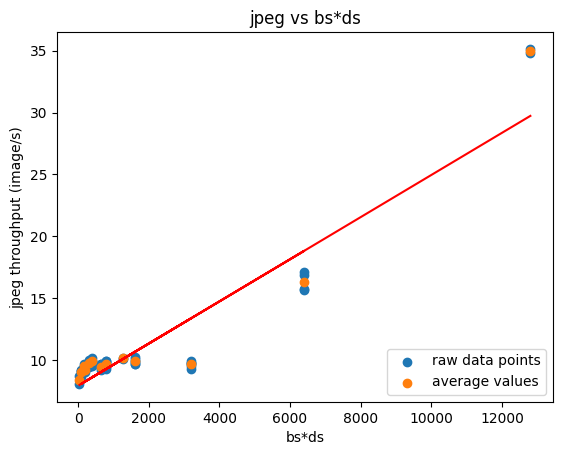

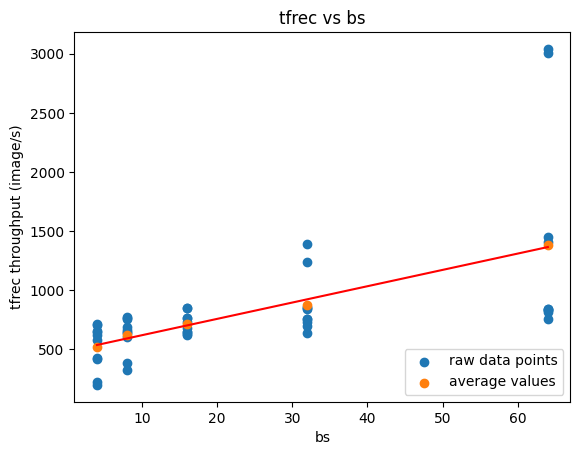

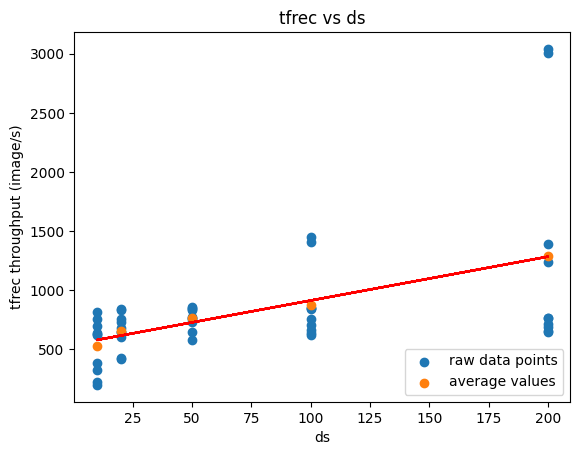

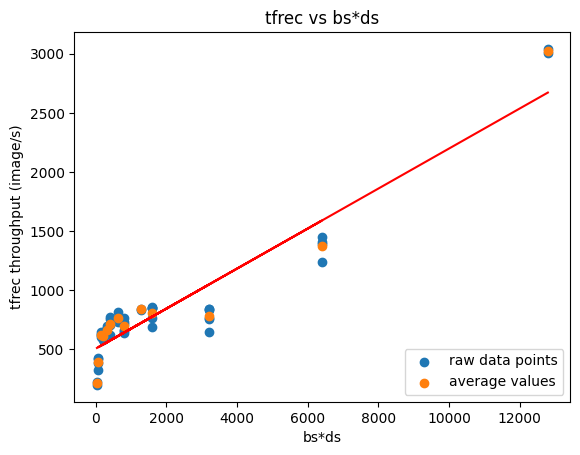

In [26]:
### CODING TASK ###

import pickle
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import linregress

# latest pickle file is copied from gcs into colab to use the raw data points
!gsutil cp $(gsutil ls gs://bd-coursework-zeynepdagci-storage/speed_results_*.pkl | tail -n 1) /mnt/data/speed_results.pkl

with open('/mnt/data/speed_results.pkl', 'rb') as f:
    output_obj = pickle.load(f)

# raw results and averages are extracted from the pickle file
results = output_obj['results']
averages = output_obj['averages']
rows = []
avg_rows = []

for (bs, ds, rep), jpeg, tfrec in results:
    rows.append([bs, ds, rep, jpeg, tfrec])

print("\n======= Raw Results =======")
df = pd.DataFrame(rows, columns=['bs', 'ds', 'rep', 'jpeg', 'tfrec'])
display(df) # table is displayed for raw results

for (file, param, param_value), avg_rate in averages.items():
    avg_rows.append([file, param, param_value, avg_rate])


print("\n======= Average Results =======")
avg_df = pd.DataFrame(avg_rows, columns=['file', 'param', 'param_value', 'avg_rate']).sort_values(by=['param_value'], ascending=[True])
display(avg_df) # table is displayed for average results

avg_bs_ds = df.assign(bs_ds = df['bs'] * df['ds']).groupby('bs_ds')[['jpeg', 'tfrec']].mean().rename(columns={'jpeg': 'jpeg_avg', 'tfrec': 'tfrec_avg'})
display(avg_bs_ds)


print("\n======= Linear Regression =======") # linear regression is done
# linear regression for batch size and batch number
linear_regression = []
for files in ['jpeg', 'tfrec']:
  for param in ['bs', 'ds']:
    X = df[param].values.reshape(-1, 1)
    y = df[files].values
    model = LinearRegression()
    model.fit(X, y)
    r2 = model.score(X, y)
    slope, intercept, rvalue, pvalue, stderr = linregress(X.flatten(), y)
    linear_regression.append({'param': param, 'files': files, 'coef': model.coef_[0], 'intercept': model.intercept_, 'r2': r2, 'p-value': float(f"{pvalue:6f}")})

  # linear regression for the product of batch_size and batch_number (bs*ds)
  x = (df['bs']*df['ds']).values
  y = df[files].values
  slope, intercept, rvalue, pvalue, stderr = linregress(x, y)
  X = x.reshape(-1, 1)
  model = LinearRegression()
  model.fit(X, y)
  r2 = model.score(X, y)
  linear_regression.append({'param': 'bs*ds', 'files': files, 'coef': model.coef_[0], 'intercept': model.intercept_, 'r2': r2, 'p-value': float(f"{pvalue:6f}")})

df_lr = pd.DataFrame(linear_regression)
display(df_lr)


# the output values, the averages per parameter value and the regression lines for each parameter
# and for the product of batch_size and batch_number are plotted

# RAW DATAPOINTS
def plot_results(x, y, label_x, label_y, title):
  model = LinearRegression().fit(x.reshape(-1, 1), y)
  plt.figure()
  plt.plot(x, model.predict(x.reshape(-1, 1)), color='red')
  plt.scatter(x, y, label="data points")
  plt.xlabel(label_x)
  plt.ylabel(label_y)
  plt.title(title)
  plt.legend(loc="lower right")
  plt.show()

# for jpeg files
plot_results(df['bs'].values, df['jpeg'].values, 'batch_size', 'images/sec', 'jpeg files vs batch size (raw data)')
plot_results(df['ds'].values, df['jpeg'].values, 'batch_number', 'images/sec', 'jpeg files vs batch number (raw data)')
plot_results((df['bs']*df['ds']).values, df['jpeg'].values, 'total_images (bs*ds)', 'images/sec', 'jpeg files vs total number of images (raw data)') # total number of images (bs*ds) is shown for jpeg files

# for tfrec files
plot_results(df['bs'].values, df['tfrec'].values, 'batch_size', 'images/sec', 'tfrec files vs batch size (raw data)')
plot_results(df['ds'].values, df['tfrec'].values, 'batch_number', 'images/sec', 'tfrec files vs batch number (raw data)')
plot_results((df['bs']*df['ds']).values, df['tfrec'].values, 'total_images (bs*ds)', 'images/sec', 'tfrec files vs total number of images (raw data)') # total number of images (bs*ds) is shown for tfrec files


# AVERAGE DATAPOINTS
def plot_avg_results(values_x, avg_rates_y, label_x, label_y, title):
  model = LinearRegression().fit(values_x.reshape(-1, 1), avg_rates_y)
  plt.figure()
  plt.plot(values_x, model.predict(values_x.reshape(-1, 1)), color='red')
  plt.scatter(values_x, avg_rates_y, label="data points")
  plt.xlabel(label_x)
  plt.ylabel(label_y)
  plt.title(title)
  plt.legend(loc="lower right")
  plt.show()

# jpeg files vs batch size
jpeg_bs = (avg_df.query('param == "bs" and file == "jpeg"').sort_values('param_value'))
plot_avg_results(jpeg_bs['param_value'].values, jpeg_bs['avg_rate'].values, 'batch_size', 'images/sec', 'jpeg files vs batch size (average)')

# jpeg files vs batch number
jpeg_ds = (avg_df.query('param == "ds" and file == "jpeg"').sort_values('param_value'))
plot_avg_results(jpeg_ds['param_value'].values, jpeg_ds['avg_rate'].values, 'batch_number', 'images/sec', 'jpeg files vs batch number (average)')

# tfrecord files vs batch size
tfrec_bs = (avg_df.query('param == "bs" and file == "tfrec"').sort_values('param_value'))
plot_avg_results(tfrec_bs['param_value'].values, tfrec_bs['avg_rate'].values, 'batch_size', 'images/sec', 'tfrecord files vs batch size (average)')

# tfrecord files vs batch number
tfrec_ds = (avg_df.query('param == "ds" and file == "tfrec"').sort_values('param_value'))
plot_avg_results(tfrec_ds['param_value'].values, tfrec_ds['avg_rate'].values, 'batch_number', 'images/sec', 'tfrecord files vs batch number (average)')

# average results for total_images (bs*ds)
plot_avg_results(avg_bs_ds.index.values, avg_bs_ds['jpeg_avg'].values, 'total images (bs*ds)', 'images/sec', 'jpeg files vs total number of images (average)')
plot_avg_results(avg_bs_ds.index.values, avg_bs_ds['tfrec_avg'].values, 'total images (bs*ds)', 'images/sec', 'tfrecord files vs total number of images (average)')


# COMBINED GRAPH
def plot_combined_results(df, param, col):
  df['bs*ds'] = df['bs']*df['ds']

  x = df[param].to_numpy().reshape(-1, 1)
  y = df[col].to_numpy()
  model = LinearRegression().fit(x, y)
  coef, intercept = model.coef_[0], model.intercept_
  mean = df.groupby(param)[col].mean()
  plt.figure()
  plt.plot(x, model.predict(x.reshape(-1, 1)), color='red')
  plt.scatter(x, y, label="raw data points")
  plt.scatter(mean.index.values, mean.values, label="average values")
  plt.xlabel(param)
  plt.ylabel(f'{col} throughput (image/s)')
  plt.title(f"{col} vs {param}")
  plt.legend(loc="lower right")
  plt.show()

plot_combined_results(df, 'bs', 'jpeg')
plot_combined_results(df, 'ds', 'jpeg')
plot_combined_results(df, 'bs*ds', 'jpeg')
plot_combined_results(df, 'bs', 'tfrec')
plot_combined_results(df, 'ds', 'tfrec')
plot_combined_results(df, 'bs*ds', 'tfrec')


# Section 3. Theoretical discussion

## Task 3: Discussion in context. (24%)

In this task we refer an idea that is introduced in this paper:
-	Alipourfard, O., Liu, H. H., Chen, J., Venkataraman, S., Yu, M., & Zhang, M. (2017). [Cherrypick: Adaptively unearthing the best cloud configurations for big data analytics.](https://people.irisa.fr/Davide.Frey/wp-content/uploads/2018/02/cherrypick.pdf). In USENIX NSDI  17 (pp. 469-482).

Alipourfard et al (2017) introduce  the prediction an optimal or near-optimal cloud configuration for a given compute task.

### 3a)	Contextualise

Relate the previous tasks and the results to this concept. (It is not necessary to work through the full details of the paper, focus just on the main ideas). To what extent and under what conditions do the concepts and techniques in the paper apply to the task in this coursework? (12%)

### 3b)	Strategise

Define - as far as possible - concrete strategies for different application scenarios (batch, stream) and discuss the general relationship with the concepts above. (12%)

Provide the answers to these questions in your report.


In [ ]:
# part 3a and 3b are explained in the report.

## Final cleanup

Once you have finshed the work, you can delete the buckets, to stop incurring cost that depletes your credit.

In [ ]:
!gsutil -m rm -r $BUCKET/* # Empty your bucket
!gsutil rb $BUCKET # delete the bucket